In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4889
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 41
[LightGBM] [Info] Start training from score 3.635211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

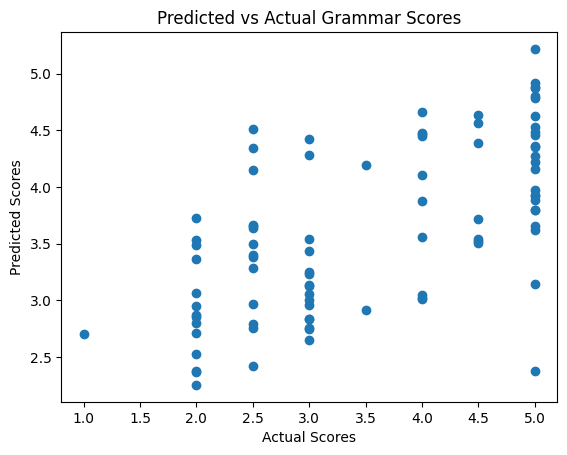

Submission file saved as 'submission.csv'


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from multiprocessing import Pool  # Import Pool for parallel processing

train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv')

# Feature extraction function with multiple audio features
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr).mean(axis=1)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
        zcr = librosa.feature.zero_crossing_rate(y).mean()
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
        rms = librosa.feature.rms(y=y).mean()
        
        # Combine all features into a single array
        features = np.hstack([mfcc, chroma, [zcr], spectral_contrast, [rms]])
        return features
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Extract features for training data (with caching)
train_features = []
for filename in train_df['filename']:
    file_path = f'/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/{filename}'
    features = extract_features(file_path)
    train_features.append(features)

# Add features to the DataFrame and drop rows with missing features
train_df['features'] = train_features
train_df = train_df.dropna(subset=['features'])

# Prepare training data
X = np.vstack(train_df['features'].values)
y = train_df['label'].values

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train LightGBM model
model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate model on validation set
y_pred_val = model.predict(X_val)
pearson_corr = pearsonr(y_val, y_pred_val)[0]
print(f'Pearson Correlation on Validation Set: {pearson_corr:.4f}')
print(f'Mean Squared Error: {mean_squared_error(y_val, y_pred_val):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val, y_pred_val):.4f}')

# Visualize predicted vs actual scores
plt.scatter(y_val, y_pred_val)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Grammar Scores")
plt.show()

# Extract features for test data (with caching)
test_features = []
for filename in test_df['filename']:
    file_path = f'/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/{filename}'
    features = extract_features(file_path)
    test_features.append(features)

# Add features to the DataFrame and drop rows with missing features in test data
test_df['features'] = test_features
test_df = test_df.dropna(subset=['features'])

# Prepare test data for prediction
X_test = np.vstack(test_df['features'].values)
X_test_scaled = scaler.transform(X_test)

# Predict on test data
test_predictions = model.predict(X_test)

# Prepare submission file
submission = pd.DataFrame({'filename': test_df['filename'], 'label': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")






